In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

from load_wastewater_data import load_systems_data
from plotting_tools import *

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_0_0001", "constant_decay_0_025"

In [3]:
plot_path = f"../plots/wastewater_model/correlation"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

Load data

In [4]:
df_wastewater = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")

df_wastewater["hours"] = df_wastewater["minutes"]/60

# summarize df_wastewater data
df_wastewater_avg = df_wastewater.groupby(["time_in_days", "sampling_point"]).mean().reset_index()[["time_in_days", "hours", "sampling_point", "COVID_copies/l"]]

In [5]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"
df_prevalence = pd.read_csv(os.path.join(infection_model_output_path, "console_output_summarized.csv"))

# aggregate over timesteps per simulation id and then calculate average across all simulations
df_prevalence_avg = df_prevalence.groupby(["time"])[["I_total"]].mean().reset_index()

In [6]:
# combine columns
df_combined = df_wastewater_avg.merge(df_prevalence_avg, left_on="hours", right_on="time", how="left")
df_combined = df_combined[[int(x)==x for x in df_combined.hours]] # only subselect full hours (we are not considering any other time shift)
df_combined["time_in_days"] = df_combined["hours"]/24

In [7]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [8]:
df_combined.head()

,time_in_days,hours,sampling_point,COVID_copies/l,time,I_total
304,0.041667,1.0,1,63.077782,1.0,8.82
305,0.041667,1.0,10,60.673214,1.0,8.82
306,0.041667,1.0,11,0.000000,1.0,8.82
307,0.041667,1.0,12,63.879334,1.0,8.82
308,0.041667,1.0,13,56.247831,1.0,8.82


In [9]:
def get_crosscorrelation_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["I_total"], lag) for lag in lags_in_hours]

In [10]:
lag_in_hours = 36 # 65
# lag_in_minutes = lag_in_hours * 60
# n_5_minute_lags = int(lag_in_minutes/5)
print(f"Lag in hours: {lag_in_hours}")
correlations = get_crosscorrelation_for_one_station(df_combined, "16", [-lag_in_hours, 0, lag_in_hours])

Lag in hours: 36


In [11]:
# Define variables
sampling_location = "16"
lag = 36

df_wastewater_sub = df_wastewater_avg.loc[df_wastewater_avg.sampling_point==sampling_location, :].sort_values("hours")
df_wastewater_sub["time_in_days"] = df_wastewater_sub["hours"]/24
df_prevalence_avg["time_in_days"] = df_prevalence_avg["time"]/24


In [12]:
df_prevalence_avg["time_in_days_plus_lag"] = df_prevalence_avg["time_in_days"] + lag/24
df_prevalence_avg["time_in_days_minus_lag"] = df_prevalence_avg["time_in_days"] - lag/24

min_time = df_prevalence_avg["time_in_days"].min()
max_time = df_prevalence_avg["time_in_days"].max()

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [14]:
df_prevalence_avg.time_in_days.unique()[df_prevalence_avg.time_in_days.unique()>2.2][1:20]

array([2.25      , 2.29166667, 2.33333333, 2.375     , 2.41666667,
       2.45833333, 2.5       , 2.54166667, 2.58333333, 2.625     ,
       2.66666667, 2.70833333, 2.75      , 2.79166667, 2.83333333,
       2.875     , 2.91666667, 2.95833333, 3.        ])

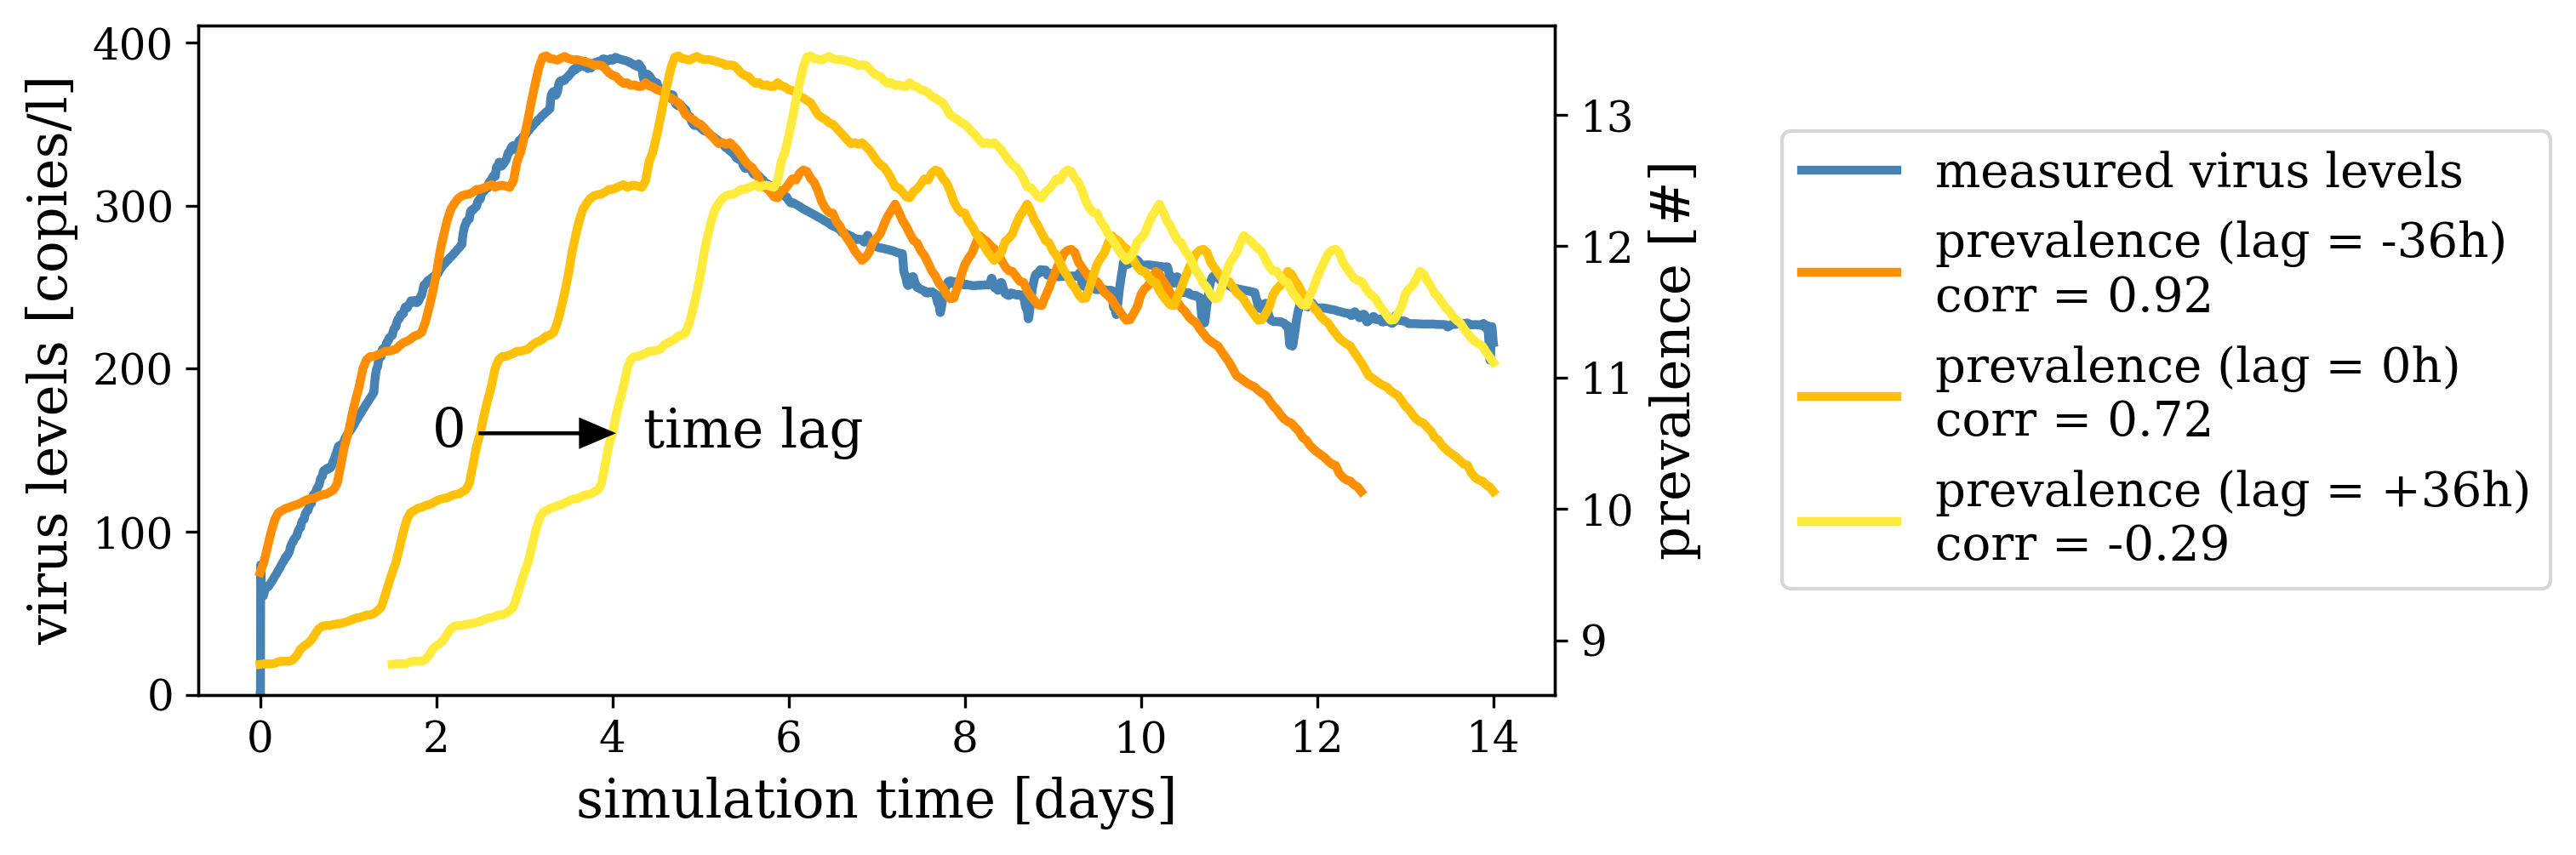

In [24]:
shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (12*0.9,4*0.9), dpi=300)

# Plot copies/l on primary y-axis
sns.lineplot(x=df_wastewater_sub["time_in_days"], y=df_wastewater_sub["COVID_copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2.5)
ax1.set_ylabel('virus levels [copies/l]')#, color='steelblue')
ax1.tick_params(axis='y')#, labelcolor='b')

# Create secondary y-axis for prevalence
ax2 = ax1.twinx()
# minus lag
df_prevalence_sub = df_prevalence_avg.loc[(df_prevalence_avg["time_in_days_minus_lag"] >= min_time) & (df_prevalence_avg["time_in_days_minus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_minus_lag"], y=df_prevalence_sub["I_total"], label=f"prevalence (lag = -{lag}h)\ncorr = {correlations[0]:.2f}", ax=ax2, color=shades_of_yellow[2], linewidth=2.5)# 'lightcoral')
# no lag
sns.lineplot(x=df_prevalence_avg["time_in_days"], y=df_prevalence_avg["I_total"], label=f"prevalence (lag = 0h)\ncorr = {correlations[1]:.2f}", ax=ax2, color=shades_of_yellow[1], linewidth=2.5)#'indianred')
# plus lag
df_prevalence_sub = df_prevalence_avg.loc[(df_prevalence_avg["time_in_days_plus_lag"] >= min_time) & (df_prevalence_avg["time_in_days_plus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_plus_lag"], y=df_prevalence_sub["I_total"], label=f"prevalence (lag = +{lag}h)\ncorr = {correlations[2]:.2f}", ax=ax2, color=shades_of_yellow[0], linewidth=2.5)# 'lightcoral')

# Customize secondary y-axis
ax2.set_ylabel('prevalence [#]')#, color='indianred')
ax2.tick_params(axis='y')

# ax1.annotate(
#     "lag", 
#     xy=(5, 9.104), 
#     xytext=(3, 100),
#     arrowprops=dict(facecolor='black', shrink=0.05, headwidth=8, width=10)
# )

# Draw arrow
arrow_x = 2.5
arrow_y = df_prevalence_avg.loc[df_prevalence_avg["time_in_days"]==arrow_x, "I_total"].iloc[0]
offset = lag/24  # Example offset for the arrow
head_length = 0.35
ax2.arrow(arrow_x, arrow_y, offset-head_length-0.01, 0, head_width=0.2, head_length=head_length, fc='black', ec='black', zorder=5)
#ax2.arrow(arrow_x + (offset), arrow_y, -(offset-head_length-0.01), 0, head_width=0.3, head_length=head_length, fc='black', ec='black', zorder=5)
ax2.annotate("time lag", xy=(arrow_x + offset + head_length, arrow_y-0.11))
ax2.annotate("0", xy=(arrow_x - (head_length + 0.3) + 0.1, arrow_y-0.11))

# Customize x-axis
ax1.set_xlabel('simulation time [days]')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

ax1.set_ylim(bottom = 0)

# Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_trajectories_station_{sampling_location}.png"), dpi=300)

##### Cross correlation based on average values

In [25]:
from matplotlib.patches import Rectangle

In [26]:
df_combined

,time_in_days,hours,sampling_point,COVID_copies/l,time,I_total
304,0.041667,1.0,1,63.077782,1.0,8.820
305,0.041667,1.0,10,60.673214,1.0,8.820
306,0.041667,1.0,11,0.000000,1.0,8.820
307,0.041667,1.0,12,63.879334,1.0,8.820
308,0.041667,1.0,13,56.247831,1.0,8.820
...,...,...,...,...,...,...
107515,14.000000,336.0,5,205.379348,336.0,10.132
107516,14.000000,336.0,6,115.213019,336.0,10.132
107517,14.000000,336.0,7,219.704289,336.0,10.132
107518,14.000000,336.0,8,219.670623,336.0,10.132


In [27]:
df_corr = pd.DataFrame()
max_lag = 45
df_corr["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_corr["lag_in_days"] = (df_corr["lag_in_h"]/24)
for sampling_location in df_combined["sampling_point"].unique():
    df_corr[sampling_location] = get_crosscorrelation_for_one_station(df_combined, sampling_location, df_corr["lag_in_h"])
df_corr = df_corr.set_index("lag_in_h")

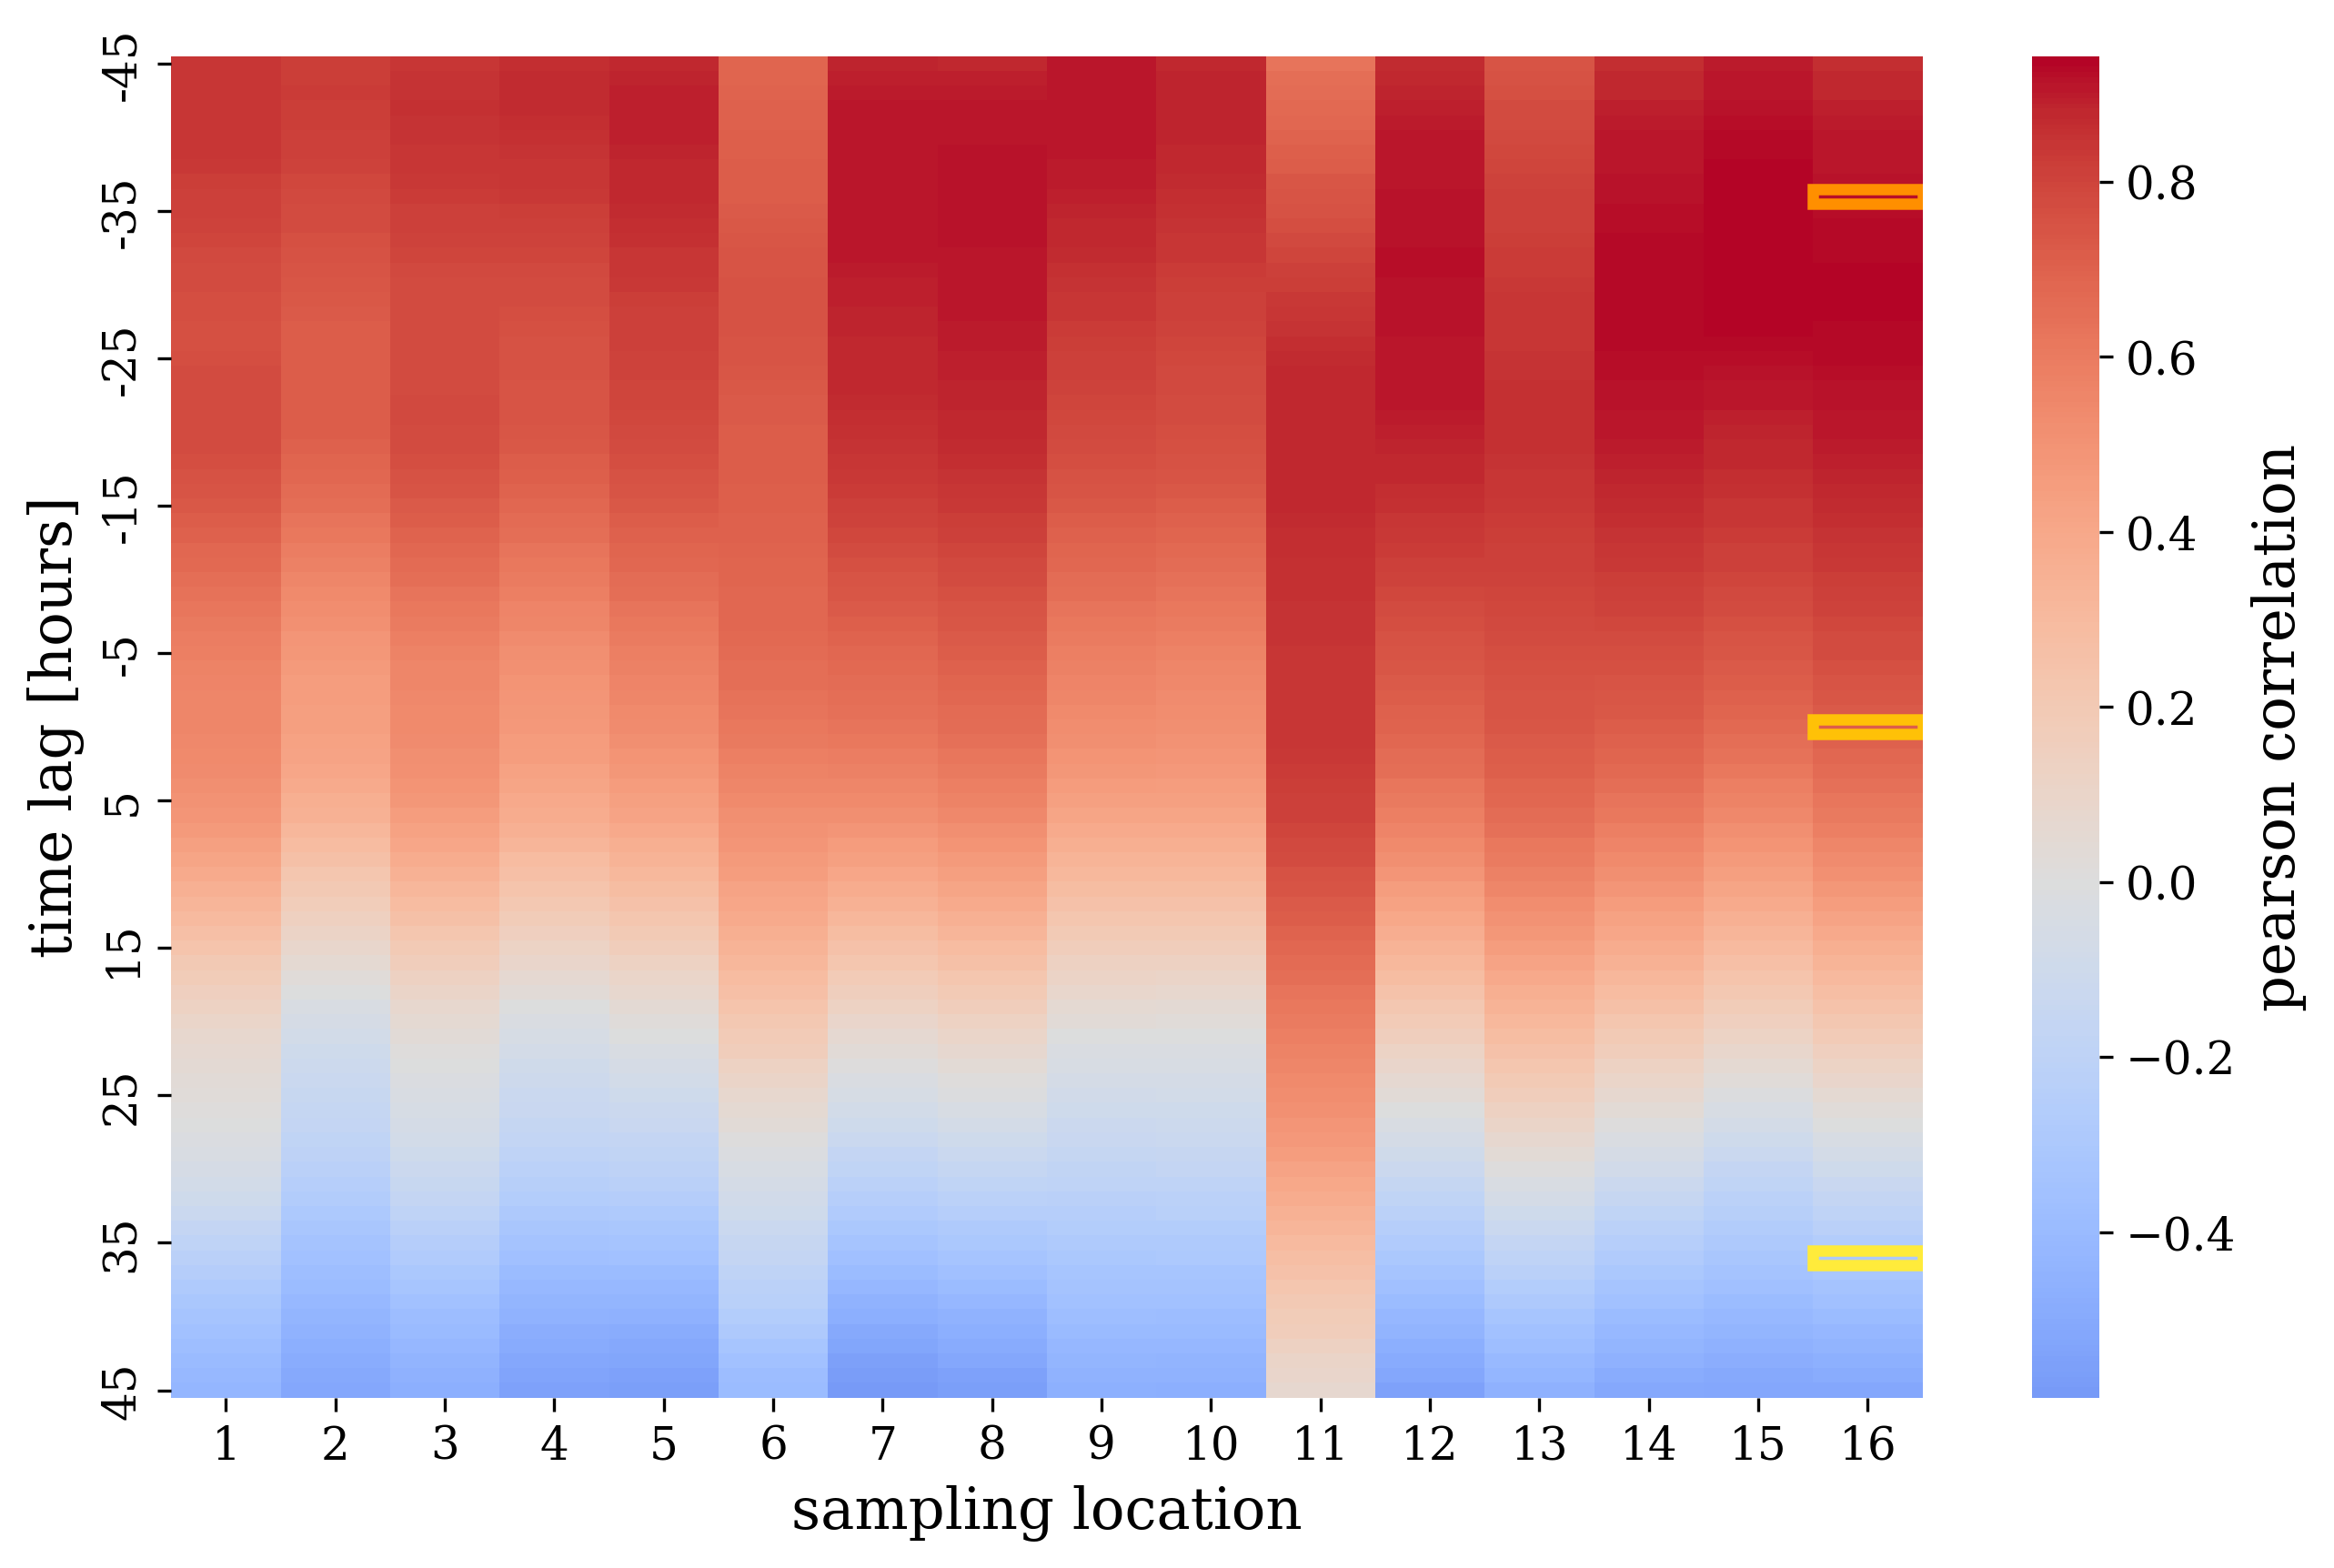

In [29]:
fig, ax = plt.subplots(figsize = (9,6), dpi=300) 
# plt.title("Cross-Correlation between Copies/l and Prevalence")
lb = sns.heatmap(df_corr[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=10, cbar_kws={'label': 'pearson correlation'})
# sns.set(font_scale=1)
#ax.set_title("Cross-Correlation between Copies/l and Prevalence", pad=20)# ,fontsize=20)
ax.set_xlabel("sampling location")
ax.set_ylabel("time lag [hours]")

ax.add_patch(Rectangle((15, df_corr.index.get_loc(-lag)), 1, 1, fill=False, edgecolor=shades_of_yellow[2], lw=3))
ax.add_patch(Rectangle((15, df_corr.index.get_loc(0)), 1, 1, fill=False, edgecolor=shades_of_yellow[1], lw=3))
ax.add_patch(Rectangle((15, df_corr.index.get_loc(lag)), 1, 1, fill=False, edgecolor=shades_of_yellow[0], lw=3))

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_cross_correlation_avg.png"), dpi=300)